# Tutorial:   Statistics and Biomechanics  (ISB 2019, Calgary)

&copy; Todd Pataky, 2019

# Notebook 3:  Validating inferences for univariate 0D data

The purposes of this notebook is to demonstrate how probabilities (p values and critical thresholds) from classical hypothesis testing can be numerically validated using random number simulation. This notebook combines concepts from Notebooks 1 & 2.

Note that numerical validation is just one kind of validation, and only suggests validity. The only true validitation exists in the form of mathematical proofs, but this is beyond the scope of these notebooks, and is also unnecessary for understanding the meaning of hypothesis testing's probability results.

### Part 1:  Numerical validation overview

First, let's repeat the example from Notebook 2, Part 2:

In [1]:
rng(58)      %seed=58 chosen to obtain a p value close to 0.05
J     = 8;   %sample size
mu    = 80;  %true population mean
sigma = 10;  %true population SD

y     = mu + sigma * randn(J,1);
[h,p,ci,stats] = ttest(y, mu);
fprintf('One-sample t test results:  t = %.3f, p = %.3f', stats.tstat, p)

One-sample t test results:  t = -1.999, p = 0.086

We saw in Notebook 2 that the p value can be calculated using the survival function (SF) for the t statistic:

In [2]:
t     = stats.tstat;
nu    = J - 1;
p     = 2 * (1 - cdf('t', abs(t), nu));   %two-tailed inference
fprintf('p value = %.3f', p)

p value = 0.086

and that the critical t value ($t^*$) for $\alpha=0.05$ can be calculated using the inverse survival function (ISF):

In [3]:
alpha = 0.05;
tstar = icdf('t', 1 - 0.5*alpha, nu);   %two-tailed inference

fprintf('Critical threshold for alpha=%.3f = %.3f', alpha, tstar)

Critical threshold for alpha=0.050 = 2.365

How do we know that these results (the p value and the critical t value) are valid?

One way to check is to study the mathematical proofs underlying the SF and ISF. However, these are often complex, and are not essential for conceptual understanding of the p value and the critical value.

A much easier way, albeit computationally intensive, is to simulate a large number of experiments involving random data. Let's try simulating 100 experiments involving random samples of Gaussian data, then calculate the one-sample t value for each experiment:

In [4]:
rng(0)
niter  = 100;
t      = zeros(1,niter);
for i = 1:niter
    y    = mu + sigma * randn(J,1);            %random sample
    t(i) = ( mean(y) - mu ) / std(y) * J^0.5;  %t statistic (see Notebook 2, Part 2)
end

disp( t(1:10) )

  Columns 1 through 7

   -0.0288    1.8358    2.1527    0.5233   -0.9760   -0.1122    0.2008

  Columns 8 through 10

    0.4762    0.2148   -1.1933



We now have one t value for each simulated experiment. These t values form a distribution:

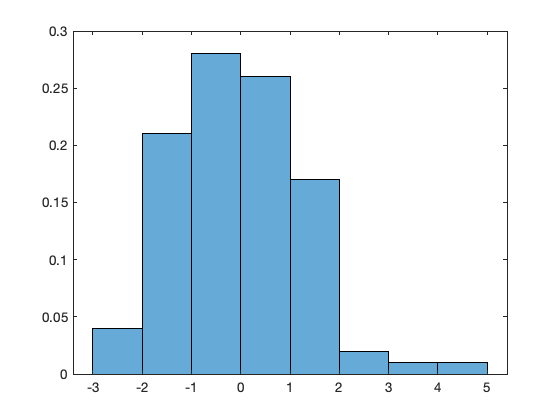

In [5]:
histogram(t, 'Normalization', 'pdf')

Note the p value from the t test above represents $P(t>u)$, where $u$ is the t value from the original dataset. To calculate the analogous p value using the t distribution we just constructed through simulation, we simply need to calculate the proportion of experiments whose t values exceed the t value from the original dataset:

In [6]:
%proportion of simulated experiments with absolute t values greater than 1.999:
p = sum( abs(t) > 1.999 ) / niter;

disp( p )

    0.0800



This is close to the p value computed above, but since we have only simulated 100 iterations, the best resolution we can get is 0.01. Let's try simulating 10,000 iterations and re-calculating:

    0.0819



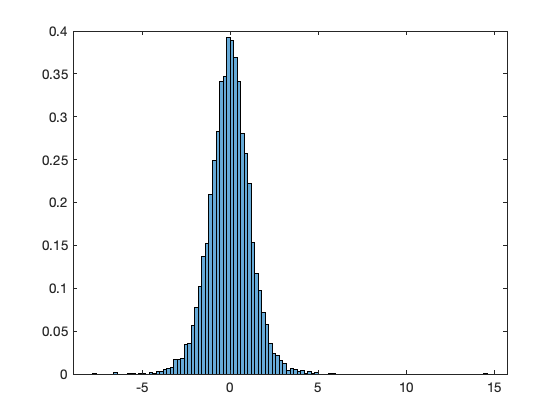

In [7]:
rng(0)
niter  = 10000;
t      = zeros(1,niter);
for i = 1:niter
    y    = mu + sigma * randn(J,1);            %random sample
    t(i) = ( mean(y) - mu ) / std(y) * J^0.5;  %t statistic (see Notebook 2, Part 2)
end

p = sum( abs(t) > 1.999 ) / niter;
disp( p )

histogram(t, 'Normalization', 'pdf')

We now have a more completely defined distribution, and the p value we calculated using it is slightly closer to the p value reported above.

How about the critical threshold?  We can use the 95th percentile (or the 97.5th perentile for two-tailed inference) of the the simulated t distribution to calculate the critical threshold as follows:

In [8]:
tstar   = prctile(t, 100*(1-0.5*alpha));
disp(tstar)

    2.2968



Like the p value, the critical threshold is quite close to the one computed analytically above (using the ISF).

___

### Part 2:  Systematic numerical validation

Above we verified just two values (the p value and the critical t value) for a single data set. This suggests that the analytical results from the SF and ISF are likely valid, but it is usually important to numerically validate: both (a) the entire SF, and (b) the entire ISF, over a range of parameter values.

For the one-sample t test this means changing the sample size and validing the entire SF and the entire ISF for each sample size.  First let's try just one sample size ($J=5$), and let's use one-tailed inference for simplicity:

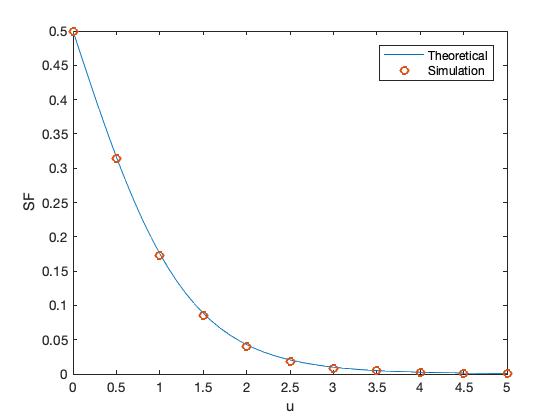

In [9]:
rng(0)
niter  = 10000;
t      = zeros(1,niter);
for i = 1:niter
    y    = mu + sigma * randn(J,1);            %random sample
    t(i) = ( mean(y) - mu ) / std(y) * J^0.5;  %t statistic (see Notebook 2, Part 2)
end


u0     = linspace(0, 5, 51);  %thresholds for the parametric (analytical) SF
u1     = linspace(0, 5, 11);  %thresholds for the numerical SF

nu     = J - 1;
sf0    = (1 - cdf('t', u0, nu));   %one-tailed inference
sf1    = zeros( 1, numel(u1) );
for i = 1:numel(u1)
    sf1(i) = mean( t > u1(i) );  %numerical SF (from simulation)
end



plot(u0, sf0, '-')
hold on
plot(u1, sf1, 'o')
xlabel('u')
ylabel('SF')
legend('Theoretical', 'Simulation')

We can see that the numerical results closely mirror the theoretical results, suggesting that the entire theoretical SF is valid.

Let's repeat for the critical threshold using the ISF:

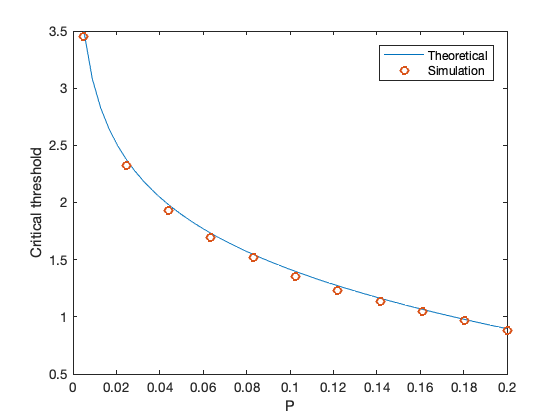

In [10]:
rng(0)
niter  = 10000;
t      = zeros(1,niter);
for i = 1:niter
    y    = mu + sigma * randn(J,1);            %random sample
    t(i) = ( mean(y) - mu ) / std(y) * J^0.5;  %t statistic (see Notebook 2, Part 2)
end


p0     = linspace(0.2, 0.005, 51);  %thresholds for the parametric (analytical) SF
p1     = linspace(0.2, 0.005, 11);  %thresholds for the numerical SF

alpha  = 0.05;
nu     = J - 1;
isf0   = icdf('t', 1 - p0, nu);   %two-tailed inference
isf1   = zeros( 1, numel(u1) );
for i = 1:numel(p1)
    isf1(i) = prctile(t, 100*(1-p1(i)));  %numerical SF (from simulation)
end



plot(p0, isf0, '-')
hold on
plot(p1, isf1, 'o')
xlabel('P')
ylabel('Critical threshold')
legend('Theoretical', 'Simulation')

Last, let's change the sample size systematically and repeat. For brevity, we'll only check the SF

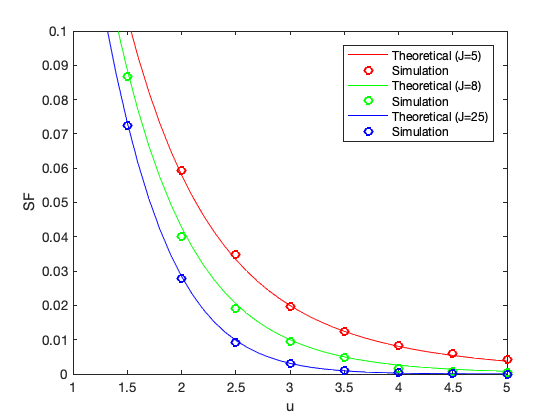

In [11]:
rng(0)
JJ     = [5 8 25];
nJ     = numel( JJ );
niter  = 10000;
t      = zeros(nJ,niter);
for i = 1:nJ
    for ii = 1:niter
        y       = mu + sigma * randn(JJ(i),1);
        t(i,ii) = ( mean(y) - mu ) / std(y) * JJ(i)^0.5;
    end
end


u0     = linspace(0, 5, 51);  %thresholds for the parametric (analytical) SF
u1     = linspace(0, 5, 11);  %thresholds for the numerical SF

sf0    = zeros( nJ, numel(u0) );
sf1    = zeros( nJ, numel(u1) );



for i = 1:nJ
    sf0(i,:) = (1 - cdf('t', u0, JJ(i)-1));   %one-tailed inference
end
for i = 1:nJ
    for ii = 1:numel(u1)
        sf1(i,ii) = mean( t(i,:) > u1(ii) );  %numerical SF (from simulation)
    end
end


colors = {'r', 'g', 'b'};
for i = 1:3
    plot(u0, sf0(i,:), '-', 'color', colors{i})
    hold on
    plot(u1, sf1(i,:), 'o', 'color', colors{i})
end
xlabel('u')
ylabel('SF')
ylim([0, 0.1])
legend('Theoretical (J=5)', 'Simulation', 'Theoretical (J=8)', 'Simulation', 'Theoretical (J=25)', 'Simulation')

___
### Summary:

This notebook has shown how to numerically validate probability values and critical threshold from hypothesis testing. These validations clarify that p values and critical thresholds pertain to the infinite set of experiments, and not to a specific experiment.

While useful for testing the thoeretical predictions of parametric distributions and probability functions, numerical simulation itself does not constitute validation. Mathematical proofs are required to validate probability functions, but this is beyond the scope of these notebooks.